## Predictive Model Notebook

In [1]:
#Import libraries
import pandas as pd
import numpy as np

#Read in data
own_df = pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/FirearmsAnalysis/main/main/data/own_df.csv")
laws_df = pd.read_csv('https://raw.githubusercontent.com/statzenthusiast921/FirearmsAnalysis/main/main/data/nlp_law_df.csv')
pop_df = pd.read_csv('https://raw.githubusercontent.com/statzenthusiast921/FirearmsAnalysis/main/main/data/states_and_pops.csv')
income_df = pd.read_csv('https://raw.githubusercontent.com/statzenthusiast921/FirearmsAnalysis/main/main/data/median_income_91-18.csv')
voting_df = pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/FirearmsAnalysis/main/main/data/prez_voting.csv")


print("Dataset 1 Dimensions: ",own_df.shape)
print("Dataset 2 Dimensions: ",laws_df.shape)
print("Dataset 3 Dimensions: ",pop_df.shape)
print("Dataset 4 Dimensions: ",income_df.shape)
print("Dataset 5 Dimensions: ",voting_df.shape)

Dataset 1 Dimensions:  (1300, 12)
Dataset 2 Dimensions:  (671, 18)
Dataset 3 Dimensions:  (1428, 4)
Dataset 4 Dimensions:  (1428, 3)
Dataset 5 Dimensions:  (408, 6)


In [2]:
#Clean up laws_df 
del laws_df['len_text'], laws_df['sentiment'], laws_df['sentiment_label'], laws_df['Suicides'],laws_df['Homicides'], laws_df['Content'],laws_df['Content_cleaned']
laws_df.head(2)

,Law ID,State,ST,Law Class,Effect,Type of Change,Effective Date,Year,min_age,wait_days,sentiment_score
0,AL1005,Alabama,AL,castle doctrine,Permissive,Modify,2006-06-01,2006,NaN,NaN,0.528648
1,AL1012,Alabama,AL,minimum age,Restrictive,Implement,2015-10-01,2015,18,NaN,0.554277


In [3]:
# Get one hot encoding of columns B
one_hot1 = pd.get_dummies(laws_df['Law Class'])
laws_df = laws_df.drop('Law Class',axis = 1)
laws_df = laws_df.join(one_hot1)

one_hot2 = pd.get_dummies(laws_df['Effect'])
laws_df = laws_df.drop('Effect',axis = 1)
laws_df = laws_df.join(one_hot2)

one_hot3 = pd.get_dummies(laws_df['Type of Change'])
laws_df = laws_df.drop('Type of Change',axis = 1)
laws_df = laws_df.join(one_hot3)

laws_df.head()

,Law ID,State,ST,Effective Date,Year,min_age,wait_days,sentiment_score,background checks,carrying a concealed weapon (ccw),...,prohibited possessor,registration,safety training required,waiting period,Permissive,Restrictive,Implement,Modify,Repeal,See note
0,AL1005,Alabama,AL,2006-06-01,2006,NaN,NaN,0.528648,0,0,...,0,0,0,0,1,0,0,1,0,0
1,AL1012,Alabama,AL,2015-10-01,2015,18,NaN,0.554277,0,0,...,0,0,0,0,0,1,1,0,0,0
2,AL1016,Alabama,AL,2015-09-01,2015,NaN,NaN,0.508875,0,0,...,0,1,0,0,1,0,0,0,1,0
3,AL1019,Alabama,AL,2000-08-01,2000,NaN,NaN,0.533408,0,0,...,0,0,0,1,1,0,0,0,1,0
4,AL1023,Alabama,AL,2015-06-04,2015,NaN,NaN,0.568907,0,0,...,1,0,0,0,0,1,1,0,0,0


In [4]:
laws_df.columns

Index(['Law ID', 'State', 'ST', 'Effective Date', 'Year', 'min_age',
       'wait_days', 'sentiment_score', 'background checks',
       'carrying a concealed weapon (ccw)', 'castle doctrine',
       'child access laws', 'dealer license', 'firearm sales restrictions',
       'minimum age', 'open carry', 'permit to purchase',
       'prohibited possessor', 'registration', 'safety training required',
       'waiting period', 'Permissive', 'Restrictive', 'Implement', 'Modify',
       'Repeal', 'See note'],
      dtype='object')

In [5]:
#We are gonna squeeze down the laws dataset to have aggregated value per State/Year combo
laws_to_join = laws_df.groupby(['State','Year'], as_index=False).agg(
    {
        #'min_age': 'pd.Series.mode',
        #'wait_days': 'pd.Series.mode',
        #'sentiment_score': 'mean',
        'background checks': 'sum',
        #'carrying a concealed weapon (ccw)': 'sum',
        #'castle doctrine':'sum',
        #'child access laws':'sum',
        #'dealer license':'sum',
        #'firearm sales restrictions':'sum',
        'minimum age':'sum',
        #'open carry':'sum',
        #'permit to purchase':'sum',
        'prohibited possessor':'sum',
        #'registration':'sum',
        #'safety training required':'sum',
        'waiting period':'sum',
        'Permissive':'sum',
        'Restrictive':'sum',
        'Implement':'sum',
        'Modify':'sum',
        'Repeal':'sum'
        
    }
)

laws_to_join.head()

,State,Year,background checks,minimum age,prohibited possessor,waiting period,Permissive,Restrictive,Implement,Modify,Repeal
0,Alabama,1994,1,0,0,0,0,1,1,0,0
1,Alabama,1998,1,0,0,0,0,1,1,0,0
2,Alabama,2000,0,0,0,1,1,0,0,0,1
3,Alabama,2006,0,0,0,0,1,0,0,1,0
4,Alabama,2015,0,1,3,0,1,4,4,0,1


In [6]:
#Join datasets - laws onto ownership
df = pd.merge(
    own_df,
    laws_to_join,
    how='left',
    on=['State','Year']
)
print("Dataset 1 Dimensions: ", own_df.shape)
print("Dataset 2 Dimensions: ", laws_to_join.shape)
print("Dataset 3 Dimensions: ", df.shape)

df.head()

Dataset 1 Dimensions:  (1300, 12)
Dataset 2 Dimensions:  (350, 11)
Dataset 3 Dimensions:  (1300, 21)


,FIP,Year,State,universl,permit,HuntLic,GunsAmmo,BackChk,ST,avg_own_est,...,Homicides,background checks,minimum age,prohibited possessor,waiting period,Permissive,Restrictive,Implement,Modify,Repeal
0,1,1991,Alabama,0,0,0.249210,-0.806069,NaN,AL,0.658029,...,9.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1992,Alabama,0,0,0.248809,-0.823236,NaN,AL,NaN,...,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1993,Alabama,0,0,0.247217,-0.631047,NaN,AL,0.612283,...,9.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1994,Alabama,0,0,0.244709,-0.611366,NaN,AL,0.545011,...,9.83,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,1995,Alabama,0,0,0.250194,-0.325590,NaN,AL,NaN,...,9.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.columns

Index(['FIP', 'Year', 'State', 'universl', 'permit', 'HuntLic', 'GunsAmmo',
       'BackChk', 'ST', 'avg_own_est', 'Suicides', 'Homicides',
       'background checks', 'minimum age', 'prohibited possessor',
       'waiting period', 'Permissive', 'Restrictive', 'Implement', 'Modify',
       'Repeal'],
      dtype='object')

In [8]:
#Fill NAs with 0s in the expanded columns
df['background checks'] = df['background checks'].fillna(0)
#df['carrying a concealed weapon (ccw)'] = df['carrying a concealed weapon (ccw)'].fillna(0)
#df['castle doctrine'] = df['castle doctrine'].fillna(0)
#df['child access laws'] = df['child access laws'].fillna(0)
#df['dealer license'] = df['dealer license'].fillna(0)
#df['firearm sales restrictions'] = df['firearm sales restrictions'].fillna(0)
df['minimum age'] = df['minimum age'].fillna(0)
#df['open carry'] = df['open carry'].fillna(0)
#df['permit to purchase'] = df['permit to purchase'].fillna(0)
df['prohibited possessor'] = df['prohibited possessor'].fillna(0)
#df['registration'] = df['registration'].fillna(0)
#df['safety training required'] = df['safety training required'].fillna(0)
df['waiting period'] = df['waiting period'].fillna(0)
df['Permissive'] = df['Permissive'].fillna(0)
df['Restrictive'] = df['Restrictive'].fillna(0)
df['Implement'] = df['Implement'].fillna(0)
df['Modify'] = df['Modify'].fillna(0)
df['Repeal'] = df['Repeal'].fillna(0)
df.head()

,FIP,Year,State,universl,permit,HuntLic,GunsAmmo,BackChk,ST,avg_own_est,...,Homicides,background checks,minimum age,prohibited possessor,waiting period,Permissive,Restrictive,Implement,Modify,Repeal
0,1,1991,Alabama,0,0,0.249210,-0.806069,NaN,AL,0.658029,...,9.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1992,Alabama,0,0,0.248809,-0.823236,NaN,AL,NaN,...,9.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1993,Alabama,0,0,0.247217,-0.631047,NaN,AL,0.612283,...,9.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1994,Alabama,0,0,0.244709,-0.611366,NaN,AL,0.545011,...,9.83,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,1995,Alabama,0,0,0.250194,-0.325590,NaN,AL,NaN,...,9.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.isnull().sum()

FIP                       0
Year                      0
State                     0
universl                  0
permit                    0
HuntLic                   0
GunsAmmo                  0
BackChk                 400
ST                        0
avg_own_est             230
Suicides                  0
Homicides                38
background checks         0
minimum age               0
prohibited possessor      0
waiting period            0
Permissive                0
Restrictive               0
Implement                 0
Modify                    0
Repeal                    0
dtype: int64

In [10]:
#Impute missing values using KNN Imputation

#1.) Too many missing values in BackChk - just delete column
del df['BackChk']

#2.) Use KNN Impute to fix NaNs in 'avg_own_est' and 'homicides'
# from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

#3.) Break out text columns - will screw with KNN 
states = pd.DataFrame(df[['State','ST']])
not_states = df.loc[:, ~df.columns.isin(['State','ST'])]

#4.) Impute the non-text columns
imputer = KNNImputer(n_neighbors=5)
not_states_fixed = pd.DataFrame(imputer.fit_transform(not_states),columns=not_states.columns)

#5.) Add the text columns back in
not_states_fixed['State'] = states['State']
not_states_fixed['ST'] = states['ST']

#6.) Display results
df = not_states_fixed
df.head()

,FIP,Year,universl,permit,HuntLic,GunsAmmo,avg_own_est,Suicides,Homicides,background checks,minimum age,prohibited possessor,waiting period,Permissive,Restrictive,Implement,Modify,Repeal,State,ST
0,1.0,1991.0,0.0,0.0,0.249210,-0.806069,0.658029,10.38,9.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alabama,AL
1,1.0,1992.0,0.0,0.0,0.248809,-0.823236,0.598988,9.46,9.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alabama,AL
2,1.0,1993.0,0.0,0.0,0.247217,-0.631047,0.612283,10.06,9.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alabama,AL
3,1.0,1994.0,0.0,0.0,0.244709,-0.611366,0.545011,9.39,9.83,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,AL
4,1.0,1995.0,0.0,0.0,0.250194,-0.325590,0.564404,9.92,9.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alabama,AL


In [11]:
df.columns

Index(['FIP', 'Year', 'universl', 'permit', 'HuntLic', 'GunsAmmo',
       'avg_own_est', 'Suicides', 'Homicides', 'background checks',
       'minimum age', 'prohibited possessor', 'waiting period', 'Permissive',
       'Restrictive', 'Implement', 'Modify', 'Repeal', 'State', 'ST'],
      dtype='object')

In [12]:
print("# of Rows: ",df.shape[0])
print("# of Rows that meet condition: ",int(df['Repeal'].sum()))

# of Rows:  1300
# of Rows that meet condition:  48


In [13]:
#Join in the population data
df['Year'] = df['Year'].astype(int)
del pop_df['index']

print("Dataset 1 Dimensions: ", df.shape)

df = pd.merge(
    df,
    pop_df,
    how='left',
    on=['State','Year']
)
print("Dataset 2 Dimensions: ", pop_df.shape)
print("Dataset 3 Dimensions: ", df.shape)

df.head()

Dataset 1 Dimensions:  (1300, 20)
Dataset 2 Dimensions:  (1428, 3)
Dataset 3 Dimensions:  (1300, 21)


,FIP,Year,universl,permit,HuntLic,GunsAmmo,avg_own_est,Suicides,Homicides,background checks,...,prohibited possessor,waiting period,Permissive,Restrictive,Implement,Modify,Repeal,State,ST,Pop
0,1.0,1991,0.0,0.0,0.249210,-0.806069,0.658029,10.38,9.90,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alabama,AL,4091025
1,1.0,1992,0.0,0.0,0.248809,-0.823236,0.598988,9.46,9.08,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alabama,AL,4139269
2,1.0,1993,0.0,0.0,0.247217,-0.631047,0.612283,10.06,9.49,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alabama,AL,4193113
3,1.0,1994,0.0,0.0,0.244709,-0.611366,0.545011,9.39,9.83,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,AL,4232965
4,1.0,1995,0.0,0.0,0.250194,-0.325590,0.564404,9.92,9.07,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Alabama,AL,4262731


In [14]:
#Change column of Year to voting_year in voting df
voting_df = voting_df.rename(columns={'Year': 'voting_year'})
voting_df.columns

Index(['State', 'voting_year', 'DEM_Votes', 'GOP_Votes', 'DEM_Perc',
       'GOP_Perc'],
      dtype='object')

In [15]:
#Make a connection possible between full dataset (every 1 year) and voting dataset (every 4 years)

#Step 1: Create a list of conditions
conditions = [
    (df['Year'] <1992),
    (df['Year'] >=1992) & (df['Year'] <1996),
    (df['Year'] >=1996) & (df['Year'] <2000),
    (df['Year'] >=2000) & (df['Year'] <2004),
    (df['Year'] >=2004) & (df['Year'] <2008),
    (df['Year'] >=2008) & (df['Year'] <2012),
    (df['Year'] >=2012) & (df['Year'] <2016),

    (df['Year'] >= 2016)
]

#Step 2: Create a list of the values to assign for each condition
values = [1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016]

#Step 3: Create a new column and use np.select to assign values to it using the lists as arguments
df['voting_year'] = np.select(conditions, values)

#Step 4: Quick spot check
test = df[['Year','voting_year']]
test.head()

,Year,voting_year
0,1991,1988
1,1992,1992
2,1993,1992
3,1994,1992
4,1995,1992


In [16]:
#Join in voting data
del voting_df['DEM_Votes'], voting_df['GOP_Votes']
voting_df['DEM_Perc'] = voting_df['DEM_Perc'].str.rstrip('%').astype('float')/100
voting_df['GOP_Perc'] = voting_df['GOP_Perc'].str.rstrip('%').astype('float')/100

print("Dataset 1 Dimensions: ", df.shape)

df = pd.merge(
    df,
    voting_df,
    how='left',
    left_on=['State','voting_year'],
    right_on = ['State','voting_year']
)


print("Dataset 2 Dimensions: ", pop_df.shape)
print("Dataset 3 Dimensions: ", df.shape)

df.head()

Dataset 1 Dimensions:  (1300, 22)
Dataset 2 Dimensions:  (1428, 3)
Dataset 3 Dimensions:  (1300, 24)


,FIP,Year,universl,permit,HuntLic,GunsAmmo,avg_own_est,Suicides,Homicides,background checks,...,Restrictive,Implement,Modify,Repeal,State,ST,Pop,voting_year,DEM_Perc,GOP_Perc
0,1.0,1991,0.0,0.0,0.249210,-0.806069,0.658029,10.38,9.90,0.0,...,0.0,0.0,0.0,0.0,Alabama,AL,4091025,1988,0.403,0.597
1,1.0,1992,0.0,0.0,0.248809,-0.823236,0.598988,9.46,9.08,0.0,...,0.0,0.0,0.0,0.0,Alabama,AL,4139269,1992,0.462,0.538
2,1.0,1993,0.0,0.0,0.247217,-0.631047,0.612283,10.06,9.49,0.0,...,0.0,0.0,0.0,0.0,Alabama,AL,4193113,1992,0.462,0.538
3,1.0,1994,0.0,0.0,0.244709,-0.611366,0.545011,9.39,9.83,1.0,...,1.0,1.0,0.0,0.0,Alabama,AL,4232965,1992,0.462,0.538
4,1.0,1995,0.0,0.0,0.250194,-0.325590,0.564404,9.92,9.07,0.0,...,0.0,0.0,0.0,0.0,Alabama,AL,4262731,1992,0.462,0.538


In [17]:
income_df.head(2)

,State,Year,Income
0,Alabama,2018,"49,936"
1,Alaska,2018,"68,734"


In [22]:
#Add in income data
income_df['Income'] = income_df['Income'].replace(',','', regex=True).astype(float)

print("Dataset 1 Dimensions: ", df.shape)

df = pd.merge(
    df,
    income_df,
    how='left',
    left_on=['State','Year'],
    right_on = ['State','Year']
)


print("Dataset 2 Dimensions: ", pop_df.shape)
print("Dataset 3 Dimensions: ", df.shape)

df.head()

Dataset 1 Dimensions:  (1300, 24)
Dataset 2 Dimensions:  (1428, 3)
Dataset 3 Dimensions:  (1300, 25)


,FIP,Year,universl,permit,HuntLic,GunsAmmo,avg_own_est,Suicides,Homicides,background checks,...,Implement,Modify,Repeal,State,ST,Pop,voting_year,DEM_Perc,GOP_Perc,Income
0,1.0,1991,0.0,0.0,0.249210,-0.806069,0.658029,10.38,9.90,0.0,...,0.0,0.0,0.0,Alabama,AL,4091025,1988,0.403,0.597,24346.0
1,1.0,1992,0.0,0.0,0.248809,-0.823236,0.598988,9.46,9.08,0.0,...,0.0,0.0,0.0,Alabama,AL,4139269,1992,0.462,0.538,25808.0
2,1.0,1993,0.0,0.0,0.247217,-0.631047,0.612283,10.06,9.49,0.0,...,0.0,0.0,0.0,Alabama,AL,4193113,1992,0.462,0.538,25082.0
3,1.0,1994,0.0,0.0,0.244709,-0.611366,0.545011,9.39,9.83,1.0,...,1.0,0.0,0.0,Alabama,AL,4232965,1992,0.462,0.538,27196.0
4,1.0,1995,0.0,0.0,0.250194,-0.325590,0.564404,9.92,9.07,0.0,...,0.0,0.0,0.0,Alabama,AL,4262731,1992,0.462,0.538,25991.0


In [23]:
#Create indicators for Census Regions

#Step 1: Create a list of conditions
conditions = [
    df['State'].isin(['Washington','Oregon','California','Nevada','Idaho','Montana','Wyoming','Utah','Arizona','Colorado','New Mexico','Alaska','Hawaii']),
    df['State'].isin(['North Dakota','South Dakota','Nebraska','Kansas','Minnesota','Iowa','Missouri','Wisconsin','Illinois','Michigan','Indiana','Ohio']),
    df['State'].isin(['Texas','Oklahoma','Arkansas','Louisiana','Mississippi','Alabama','Florida','Georgia','Kentucky','Tennessee','South Carolina','North Carolina','Virginia','West Virginia','Maryland','Delaware','District of Columbia']),
    df['State'].isin(['Pennsylvania','New York','New Jersey','Vermont','Connecticut','Massachusetts','Rhode Island','New Hampshire','Maine'])
]

#Step 2: Create a list of the values to assign for each condition
values = ['West','Midwest','South','Northeast']

#Step 3: Create a new column and use np.select to assign values to it using the lists as arguments
df['CensusRegion'] = np.select(conditions, values)
df['CensusRegion'].value_counts()

South        416
West         338
Midwest      312
Northeast    234
Name: CensusRegion, dtype: int64

In [24]:
#Create indicators for Census Divisions

#Step 1: Create a list of conditions
conditions = [
    df['State'].isin(['Washington','Oregon','California','Alaska','Hawaii']),
    df['State'].isin(['Montana','Idaho','Nevada','Wyoming','Utah','Colorado','Arizona','New Mexico']),
    df['State'].isin(['Texas','Oklahoma','Arkansas','Louisiana']),
    df['State'].isin(['Mississippi','Alabama','Kentucky','Tennessee']),
    df['State'].isin(['Florida','Georgia','South Carolina','North Carolina','Virginia','West Virginia','Maryland','District of Columbia','Delaware']),
    df['State'].isin(['North Dakota','South Dakota','Nebraska','Kansas','Iowa','Missouri','Minnesota']),
    df['State'].isin(['Wisconsin','Illinois','Michigan','Indiana','Ohio']),
    df['State'].isin(['Pennsylvania','New York','New Jersey']),
    df['State'].isin(['Vermont','Connecticut','Massachusetts','Rhode Island','New Hampshire','Maine'])

]

#Step 2: Create a list of the values to assign for each condition
values = ['Pacific','Mountain','West South Central','East South Central',
          'South Atlantic','West North Central','East North Central',
          'Middle Atlantic','New England']

#Step 3: Create a new column and use np.select to assign values to it using the lists as arguments
df['CensusDivision'] = np.select(conditions, values)
df['CensusDivision'].value_counts()

Mountain              208
South Atlantic        208
West North Central    182
New England           156
Pacific               130
East North Central    130
East South Central    104
West South Central    104
Middle Atlantic        78
Name: CensusDivision, dtype: int64

In [25]:
test = df[['CensusRegion','CensusDivision']]
test = test.drop_duplicates()
test = test.sort_values(by='CensusRegion', ascending=True)
test

,CensusRegion,CensusDivision
312,Midwest,East North Central
364,Midwest,West North Central
156,Northeast,New England
754,Northeast,Middle Atlantic
0,South,East South Central
78,South,West South Central
182,South,South Atlantic
26,West,Pacific
52,West,Mountain


### Model #0: Poisson Regression

In [26]:
df.columns

Index(['FIP', 'Year', 'universl', 'permit', 'HuntLic', 'GunsAmmo',
       'avg_own_est', 'Suicides', 'Homicides', 'background checks',
       'minimum age', 'prohibited possessor', 'waiting period', 'Permissive',
       'Restrictive', 'Implement', 'Modify', 'Repeal', 'State', 'ST', 'Pop',
       'voting_year', 'DEM_Perc', 'GOP_Perc', 'Income', 'CensusRegion',
       'CensusDivision'],
      dtype='object')

In [27]:
import patsy
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson


fam = Poisson()
f = 'Suicides ~ Homicides + universl + permit + HuntLic + GunsAmmo + avg_own_est + Permissive + DEM_Perc+Income'
y, X = patsy.dmatrices(f, df, return_type='matrix')

p_model = sm.GLM(y, X, family=fam)

result = p_model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Suicides   No. Observations:                 1300
Model:                            GLM   Df Residuals:                     1290
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2629.5
Date:                Wed, 27 Jul 2022   Deviance:                       351.80
Time:                        18:08:13   Pearson chi2:                     352.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.6925      0.134     12.677      

### Model #1: XGBoost

In [88]:
#1.) Create X and y
from sklearn.model_selection import train_test_split
X = df[['universl', 'permit', 'HuntLic', 'GunsAmmo',
       'avg_own_est', 'Suicides', 'background checks',
       'minimum age', 'prohibited possessor',
       'waiting period', 'Permissive','Restrictive',
       'Implement', 'Modify','Repeal','Pop']]

y = df['Homicides']

#2.) Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#3.) Fit the model
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=1000,objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False, early_stopping_rounds=5,eval_set=[(X_test,y_test)])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [15]:
#4.) Make predictions
predictions = model.predict(X_test)
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 0.821343256851343


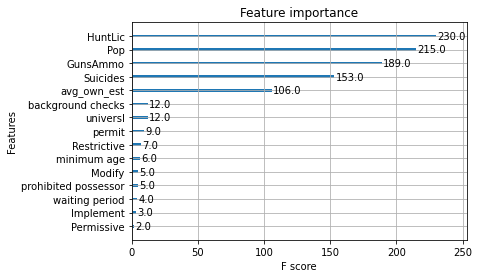

In [16]:
#5.) Plot Feature Importance
from matplotlib import pyplot
from xgboost import plot_importance

plot_importance(model)
pyplot.show()

<ipython-input-17-9f903d327901>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


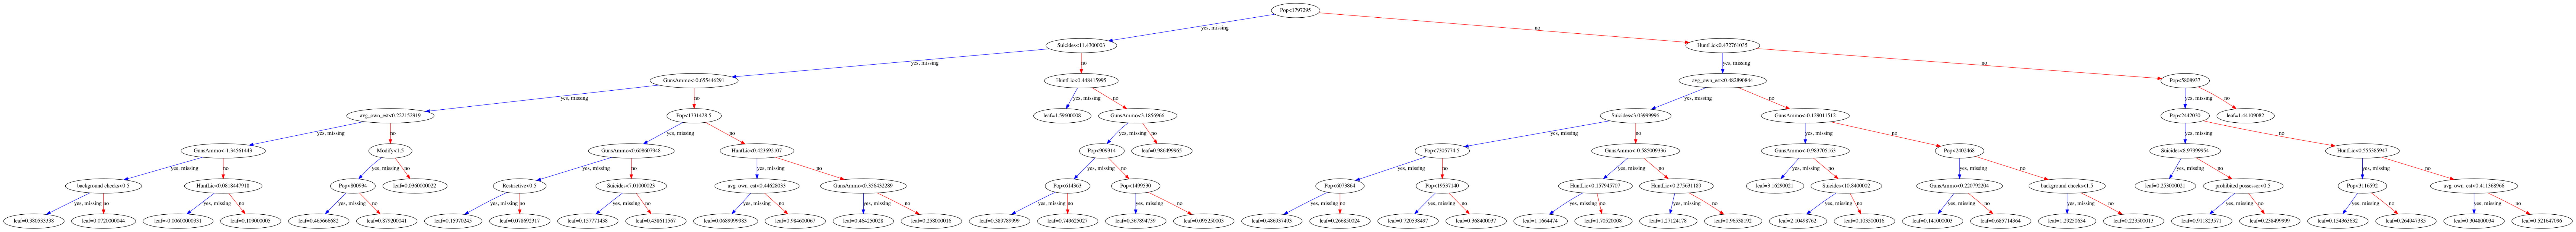

In [17]:
#6.) Plot entire decision tree
from xgboost import plot_tree
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source

tree = model.get_booster().get_dump(dump_format='dot')[0]

# plot/save fig
prop = FontProperties()
prop.set_file('Arial.ttf')
fig, ax = plt.subplots(figsize=(170, 170))
plot_tree(model, ax=ax, fontproperties=prop)
plt.savefig("test.png")
fig.show()

### Model #2.) Linear Model

In [18]:
#1.) Import libraries
import statsmodels.api as sm

#2.) Set up model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Homicides   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     56.20
Date:                Mon, 18 Jul 2022   Prob (F-statistic):          2.04e-135
Time:                        13:45:11   Log-Likelihood:                -2639.3
No. Observations:                1300   AIC:                             5313.
Df Residuals:                    1283   BIC:                             5400.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2866      0.333     -3.859      0.000      -1.941      -0.633
universl                 0.6493      0.164      3.955      0.000       0.327       0.971
permit                  -0.2076      0.172     -1.208      0.227      -0.545       0.130
HuntLic                 -3.5300      0.417     -8.462      0.000      -4.348      -2.712
GunsAmmo                -1.4718      0.095    -15.474      0.000      -1.658      -1.285
avg_own_est              6.1121      0.694      8.801      0.000       4.750       7.474
Suicides                 0.4384      0.033     13.188      0.000       0.373       0.504
background checks       -0.0716      0.223     -0.321      0.749      -0.510       0.367
minimum age              0.1954      0.259      0.755      0.450      -0.312       0.703
prohibited possessor    -0.1611      0.211     -0.764      0.445      -0.575       0.253
waiting period           0.3222      0.314      1.025      0.306      -0.295       0.939
Permissive              -0.8784      1.351     -0.650      0.516      -3.529       1.772
Restrictive             -1.2198      1.390     -0.877      0.380      -3.947       1.508
Implement                1.2307      1.365      0.901      0.368      -1.448       3.909
Modify                   1.0321      1.359      0.759      0.448      -1.634       3.698
Repeal                   1.0757      1.348      0.798      0.425      -1.569       3.720
Pop                   7.279e-08   9.33e-09      7.798      0.000    5.45e-08    9.11e-08
==============================================================================
Omnibus:                      137.575   Durbin-Watson:                   0.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.709
Skew:                           0.741   Prob(JB):                     1.95e-48
Kurtosis:                       4.363   Cond. No.                     5.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model #3: Decision Tree Regression

In [19]:
#1. Import libraries
from sklearn.tree import DecisionTreeRegressor

#2.) Set up X and y
X = df[['universl', 'permit', 'HuntLic', 'GunsAmmo',
       'avg_own_est', 'Suicides', 'background checks',
       'minimum age', 'prohibited possessor',
       'waiting period', 'Permissive','Restrictive',
       'Implement', 'Modify','Repeal','Pop']]

y = df['Homicides']

#3.) Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#4.) Fit the model
regressor = DecisionTreeRegressor(random_state=0,max_depth=3)
model = regressor.fit(X_train,y_train)

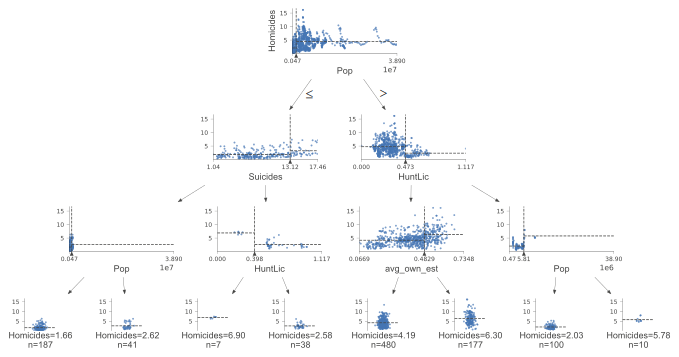

In [20]:
#5.) Plot the decision tree
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(regressor, X_train, y_train,
                target_name="Homicides",
                feature_names=X_train.columns)
viz

In [21]:
#6.) Look at Mean Absolute Error

#Calculate Results
mae_train = mean_absolute_error(y_train, model.predict(X_train)).round(4)
mae_test = mean_absolute_error(y_test, model.predict(X_test)).round(4)

#Display results
print(f"MAE (train): {mae_train}")
print(f"MAE (test): {mae_test}")

MAE (train): 1.3747
MAE (test): 1.3711


In [22]:
#7.) Calculate feature importance
importance = pd.DataFrame(model.feature_importances_)

names = pd.DataFrame(X_train.columns)
names['importance'] = importance
feat_imp = names.rename(columns={0: 'features'})
feat_imp = feat_imp.sort_values(by=['importance'], ascending=False)
feat_imp = feat_imp[feat_imp['importance']>0]
feat_imp

,features,importance
15,Pop,0.494625
2,HuntLic,0.251859
4,avg_own_est,0.224257
5,Suicides,0.029259


### Model #4. Random Forest

In [23]:
#1.) Import libraries
from sklearn.ensemble import RandomForestRegressor

#2.) Set up X and y
X = df[['universl', 'permit', 'HuntLic', 'GunsAmmo',
       'avg_own_est', 'Suicides', 'background checks',
       'minimum age', 'prohibited possessor',
       'waiting period', 'Permissive','Restrictive',
       'Implement', 'Modify','Repeal','Pop']]

y = df['Homicides']


#3.) Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#4.) Fit the model
rf = RandomForestRegressor(
    n_estimators = 300, 
    max_features = 'sqrt', 
    max_depth = 5, 
    random_state = 18
).fit(X_train, y_train)

In [24]:
#5.) Calculate Mean Absolute Error

#Calculate statistics
mae_train = mean_absolute_error(y_train, rf.predict(X_train)).round(4)
mae_test = mean_absolute_error(y_test, rf.predict(X_test)).round(4)

#Display results
print(f"MAE (train): {mae_train}")
print(f"MAE (test): {mae_test}")

MAE (train): 1.0761
MAE (test): 1.1984


<BarContainer object of 16 artists>

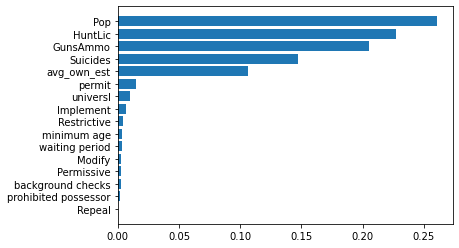

In [25]:
#6.) Calculate feature importance

feat_imp_nums = rf.feature_importances_
names = pd.DataFrame(X_train.columns)
names['importance'] = feat_imp_nums
feat_imp = names.rename(columns={0: 'features'})
feat_imp = feat_imp.sort_values(by=['importance'], ascending=True)
feat_imp = feat_imp[feat_imp['importance']>0]

plt.barh(feat_imp['features'], feat_imp['importance'])

### Classify laws as permissive or restrictive

In [26]:
#1.) Create X and y
from sklearn.model_selection import train_test_split
df['Permissive'] = np.where(df['Permissive']==0,0,1)


X = df[['universl', 'permit', 'HuntLic', 'GunsAmmo',
       'avg_own_est', 'Suicides', 'background checks',
       'minimum age', 'prohibited possessor',
       'waiting period',
       'Implement', 'Modify','Repeal','Pop','Homicides']]

y = df['Permissive']

#2.) Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [27]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [28]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9807692307692307


In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [30]:
%matplotlib inline

In [31]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[233,   1],
       [  4,  22]])